### Problem 1: Signal reconstruction with $l_{1}$-penalization ( 4 points).
1. Propose three test signals $x_{i}, i=1, \ldots, 1000$ : e.g., piece-wise linear continuous, piecewise linear discontinuous, quadratic spline.
2. Corrupt your signal adding Gaussian and/or random bounded noise
$$
y=x+\xi
$$
3. For each of three test signals run a recovery procedure with penalties $\left\|D_{1} \hat{x}\right\|_{2},\left\|D_{1} \hat{x}_{1}\right\|_{1},\left\|D_{2} \hat{x}\right\|_{1}$.
4. Explore dependency on the regularizer weight $\gamma$. Plot penalty (e.g. $\left\|D_{1} \hat{x}\right\|_{2}$ ) vs $\|y-x\|_{2}$ for different $\gamma$, you'll get the curve implicitly parameters by $\gamma$. Which $\gamma$ looks like the optimal choice for each case?
$$
\begin{gathered}
D_{1}=\left(\begin{array}{cccccc}
1 & -1 & 0 & \ldots & 0 & 0 \\
0 & 1 & -1 & \ldots & 0 & 0 \\
\ldots & \ldots & \ldots & \ldots & \ldots & \ldots \\
0 & 0 & 0 & \ldots & 1 & -1
\end{array}\right), \\
D_{2}=\left(\begin{array}{cccccccc}
1 & -2 & 1 & 0 & \ldots & 0 & 0 & 0 \\
0 & 1 & -2 & 1 & \ldots & 0 & 0 & 0 \\
\ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots \\
0 & 0 & 0 & 0 & \ldots & 1 & -2 & 1
\end{array}\right) .
\end{gathered}
$$

1.1
Propose three test signals $x_{i}, i=1, \ldots, 1000$ : e.g., piece-wise linear continuous, piecewise linear discontinuous, quadratic spline.
- - - - - 
- piece-wise linear continuous $\\ f(x) \begin{cases} x^2+3  & \text { if } x<0 \\ 3-4x & \text { if } x>=0 \text { and } x<3 \\ x-12 & \text { if } x>=10\end{cases}$
- piece-wise linear discontinuous $\\ f(x) \begin{cases} 0  & \text { if } x<0 \\ 1 & \text { if } x>=0 \text { and } x<10 \\ 10 & \text { if } x>=10\end{cases}$
- quadratic spline $\\ f(x) = x^3 ,\forall x$

In [1]:
import numpy as np
from tqdm import tqdm
from scipy import interpolate
from numpy import linalg as LA
import cvxpy as cp
from matplotlib import pyplot as plt
from scipy.sparse.csgraph import laplacian
from scipy.optimize import linprog
import random
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Fixing random state for reproducibility
np.random.seed(19680801)

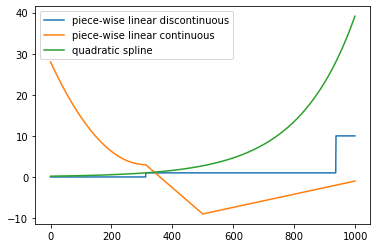

In [2]:


x = np.linspace(-5, 11, 1000)
def plot_signal(x):
    y1 = np.piecewise(x, [x < 0, ((x >= 0) & (x < 10)), x >= 10], [0, 1, 10])
    y2 = np.piecewise(x, [x < 0, ((x >= 0) & (x < 3)), x >= 3], [lambda x : x**2+3, lambda x : 3-4*x, lambda x : x - 12])
    y = np.exp(x/3)
    f = interpolate.interp1d(x, y)
    y3 = f(x)
    plt.plot(y1,  label = r'piece-wise linear discontinuous')
    plt.plot(y2,  label = r'piece-wise linear continuous')
    plt.plot(y3,  label = r'quadratic spline')

    plt.legend()
    plt.show()
plot_signal(x)

1.2

Corrupt your signal adding Gaussian and/or random bounded noise
$$
y=x+\xi
$$


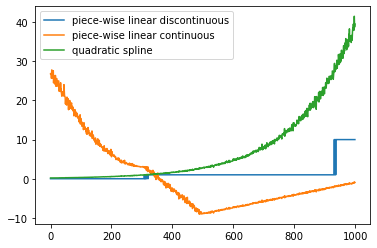

In [3]:
noise = 0.02*np.random.normal(1, 5, 1000)
x_n = x + noise
plot_signal(x_n)

1.3 
For each of three test signals run a recovery procedure with penalties $\left\|D_{1} \hat{x}\right\|_{2},\left\|D_{1} \hat{x}_{1}\right\|_{1},\left\|D_{2} \hat{x}\right\|_{1}$.
- - - -
Observed (corrupted) signal $y$, its reconstruction $x$
$$
\min \|y-x\|_{2}^{2}+\gamma\|D x\|
$$

In [4]:
n = 1000
D1 = np.diag(np.full(n,1))-np.diag(np.ones(n-1),1) 
D2 = np.diag(np.full(n,1))-2*np.diag(np.ones(n-1),1)+np.diag(np.ones(n-2),2)

def smoothing(x,d,gamma,n_n):
    y1 = np.piecewise(x, [x < 0, ((x >= 0) & (x < 10)), x >= 10], [0, 1, 10])
    y2 = np.piecewise(x, [x < 0, ((x >= 0) & (x < 3)), x >= 3], [lambda x : x**2+3, lambda x : 3-4*x, lambda x : x - 12])
    y = np.exp(x/3)
    f = interpolate.interp1d(x, y)
    y3 = f(x)
    set_y = [y1,y2,y3]
    res_x = []
    for i,y_i in (enumerate(set_y)):
        x = cp.Variable(n)
        cost = cp.sum_squares(y_i - x) + gamma * cp.norm(d*x, n_n)
        prob = cp.Problem(cp.Minimize(cost))
        prob.solve()
        res_x.append(x.value)
    return res_x,set_y 

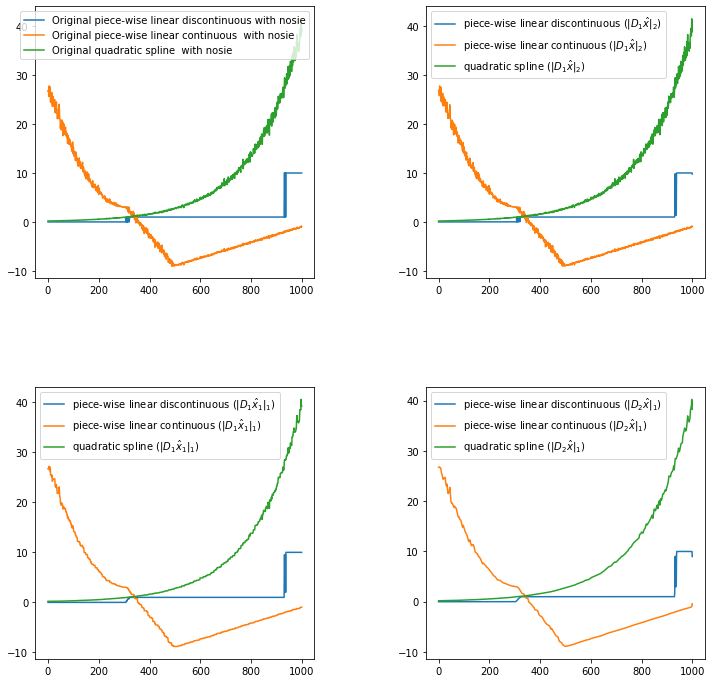

In [5]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
d_set = [D1,D2]
for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)  
    if i == 1:
        res_x,set_y = smoothing(x_n,D1,gamma=1,n_n=1)
        ax.plot(set_y[0],  label = r'Original piece-wise linear discontinuous with nosie')
        ax.plot(set_y[1],  label = r'Original piece-wise linear continuous  with nosie')
        ax.plot(set_y[2],  label = r'Original quadratic spline  with nosie')
    elif i == 2:
        res_x,set_y = smoothing(x_n,D1,gamma=1,n_n=2)
        ax.plot(res_x[0],  label = r'piece-wise linear discontinuous $(\left\|D_{1} \hat{x}\right\|_{2})$')
        ax.plot(res_x[1],  label = r'piece-wise linear continuous $(\left\|D_{1} \hat{x}\right\|_{2})$')
        ax.plot(res_x[2],  label = r'quadratic spline $(\left\|D_{1} \hat{x}\right\|_{2})$')
    elif i == 3:
        res_x,set_y = smoothing(x_n,D1,gamma=1,n_n=1)
        ax.plot(res_x[0],  label = r'piece-wise linear discontinuous $(\left\|D_{1} \hat{x}_{1}\right\|_{1})$')
        ax.plot(res_x[1],  label = r'piece-wise linear continuous $(\left\|D_{1} \hat{x}_{1}\right\|_{1})$')
        ax.plot(res_x[2],  label = r'quadratic spline $(\left\|D_{1} \hat{x}_{1}\right\|_{1})$') 
    elif i == 4:
        res_x,set_y = smoothing(x_n,D2,gamma=1,n_n=1)
        ax.plot(res_x[0],  label = r'piece-wise linear discontinuous $(\left\|D_{2} \hat{x}\right\|_{1})$')
        ax.plot(res_x[1],  label = r'piece-wise linear continuous $(\left\|D_{2} \hat{x}\right\|_{1})$')
        ax.plot(res_x[2],  label = r'quadratic spline $(\left\|D_{2} \hat{x}\right\|_{1})$')      
 
    ax.legend()  

1.4 

Explore dependency on the regularizer weight $\gamma$. Plot penalty (e.g. $\left\|D_{1} \hat{x}\right\|_{2}$ ) vs $\|y-x\|_{2}$ for different $\gamma$, you'll get the curve implicitly parameters by $\gamma$. Which $\gamma$ looks like the optimal choice for each case?


In [6]:
def reg(y_i):
    residual = []
    norm_reg = [] 
    for gamma in np.linspace(0.1, 10000.0, num=10):
        x = cp.Variable(n) 
        cost = cp.sum_squares(x - y_i) + gamma*cp.norm(D2*x, 1)   #cp.power(cp.norm(x - y_i, p=2), 2) 
        prob = cp.Problem(cp.Minimize(cost))
        prob.solve( ) 
        residual.append([np.linalg.norm(x.value - y_i, 2)])
        norm_reg.append([np.linalg.norm(D2.dot(x.value), 1)])
        
    return residual, norm_reg
         

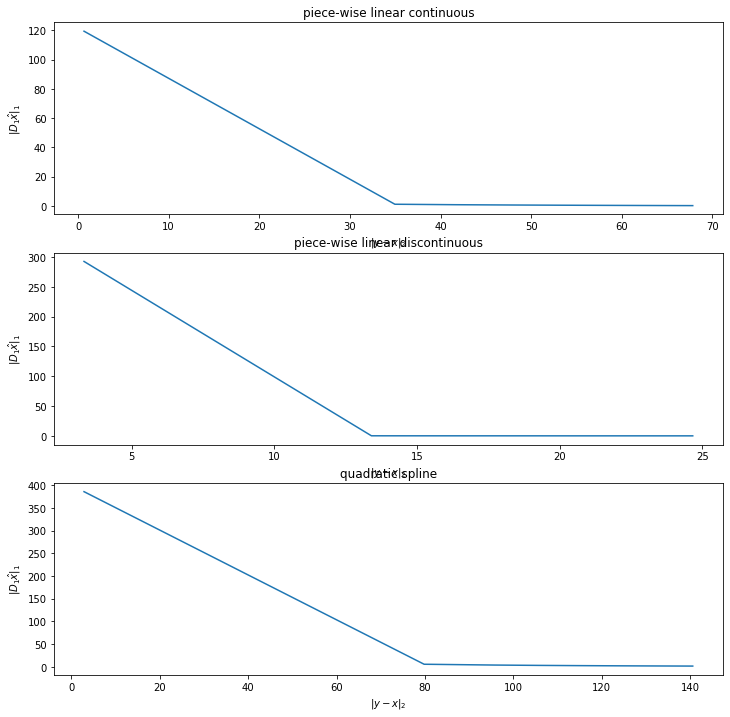

In [7]:
y1 = np.piecewise(x_n, [x_n < 0, ((x_n >= 0) & (x_n < 10)), x_n >= 10], [0, 1, 10])
y2 = np.piecewise(x_n, [x_n < 0, ((x_n >= 0) & (x_n < 3)), x_n >= 3], [lambda x_n : x_n**2+3, lambda x_n : 3-4*x_n, lambda x_n : x_n - 12])
y = np.exp(x_n/3)
f = interpolate.interp1d(x_n, y)
y3 = f(x_n)
set_y_noise = [y1,y2,y3]
name =  ["piece-wise linear continuous", "piece-wise linear discontinuous", "quadratic spline"]
fig, axs = plt.subplots(3, figsize=(12, 12))
for i,y_i in enumerate(set_y_noise):
    residual, norm_reg = reg(y_i) 
    axs[i].plot(residual, norm_reg)
    axs[i].set_title(name[i])
    axs[i].set_xlabel(r"$\|y-x\|_{2}$")
    axs[i].set_ylabel(r"$\left\|D_{1} \hat{x}\right\|_{1} $") 

### Problem 2: SDP and Schur complement (1 points)
For symmetric matrix
$$
X=\left(\begin{array}{cc}
A & B \\
B^{\top} & C
\end{array}\right)
$$
the following holds:
$$
X \succ 0 \Leftrightarrow A \succ 0, C-B^{\top} A^{-1} B \succ 0
$$
$X \succ 0 \Leftrightarrow C \succ 0, A-B C^{-1} B^{\top} \succ 0$;
The expressions $C-B^{\top} A^{-1} B$ and $A-B C^{-1} B^{\top}$ are called Schur complement.
Use this structure to describe the fact:
$$
a \in \mathcal{E}=\left\{x:(x-c)^{\top} P^{-1}(x-c) \leq 1\right\}
$$
as a Linear Matrix Inequality (LMI) with respect to $a$.

#### solution
Ellipsoid defined as
$$
\mathcal {E} = (x-c)^{\top} P^{-1}(x-c) - 1 \leq 0  
$$
containing a minimizer $x^{*}$, where $P_{(0)}\succ 0$ and $c$ is the center of ${\mathcal {E}}$.


$$
X=\left(\begin{array}{cc}
P & (x-c) \\
(x-c)^{T} & 1
\end{array}\right) \geq 0
$$

### Problem 3: Goemans-Willamson relaxation (4 points).
Create or take data for MAX CUT problem, $n \sim 20$. Construct a random Laplacian matrix $L$ with number of nonzero elements being over $80 \%$.
$$
\begin{aligned}
&\max x^{T} L x \\
&1=0, \quad i=1, \ldots, n
\end{aligned}
$$
Demonstrate four figures in one plot: $\mathrm{x}$-axis - sample number; $\mathrm{y}$-axis - objective value.
1. Naive randomization. Choose randomly $N=1000$ random cuts $x$ and plot function value for them.
2. Solution of SDP relaxation. Plot as horizontal line - the same value for all $N=1000$ samples.
3. Goemans-Williamson approximation. Depict the objective function values for $\tilde{x}$ obtained by $N=1000$ different random $\xi$.
4. Mathematical expectation (mean value) $\mathbf{E}_{\xi}\left(\tilde{x}^{T} L \tilde{x}\right)$. Plot as horizontal line. Plot as horizontal line - the same value for all $N=1000$ samples.



3.1

Naive randomization. Choose randomly $N=1000$ random cuts $x$ and plot function value for them.

In [8]:
def obj_fn_gw(x,L):
    fn = x.T @ L @ x
    return fn

 
N = 1000
n = 20
q = np.random.binomial(1, 0.8, (n,n)) 
 
A = np.triu(q, k=1).T + np.triu(q, k=1) # symmetric matrix
L = laplacian(A) #A.diagonal().sum(axis=0) - A
print(f"Percent of non-zero = {sum(L[0] != 0)/n*100}%")
naive_randomization = []
for i in range(N):
    x = np.random.choice([-1,1], (20,1))
    fv = obj_fn_gw(x,L) 
    naive_randomization.append(fv)

Percent of non-zero = 85.0%


3.2

Solution of SDP relaxation. Plot as horizontal line - the same value for all $N=1000$ samples.
- - - 
$$
\begin{gathered}
\max x^{T} L x \\
x_{i}^{2}-1=0 \quad i=1, \ldots, n
\end{gathered}
$$
Introduce $X=x x^{T}-\operatorname{rank} 1$, positive semidefinite matrix
$$
\begin{gathered}
\max \text { trace } L X \\
X_{i i}=1 \\
X \succeq 0
\end{gathered}
$$

In [9]:
# (P) In the previous hw, we solve the problem with simple constraint but this one isn't
# So I used built-in library 
# n = 1000
# def obj_sdp(x,n):
#     C = np.random.randn(n, n)
#     fn = x.T @ C @ x
#     return fn
# x = x.reshape(n,1)
# X = np.dot(x, x.T)

# define X_{0,0} = 1 in order to meet the constraint 
# X[0][0] = 1

# check X_{i i}=1 
# for i in range(n): 
#     if X[i][i] != 1: 
#         print(f"diagonal is not equal 1, {X[i][i]}")
        
# check X \succeq 0
# for i in range(n): 
#     for j in range(n): 
#         if X[i][j] < 0:
#             print(f"Not symmetric positive semidefinite matrices, {X[i][j]}")



In [10]:
# https://www.cvxpy.org/examples/basic/sdp.html
n = 20 
X = cp.Variable((n,n), symmetric=True)
constraints = [X >> 0]  # X \succeq 0
constraints += [(X[i][i]) == 1 for i in range(n)] # X_{i, i}=1 
prob = cp.Problem(cp.Maximize(cp.trace(L @ X)),
                  constraints)
prob.solve(solver=cp.CVXOPT) # https://www.cvxpy.org/tutorial/advanced/index.html#choosing-a-solver
y_res_sdp = prob.value
y_res_sdp

376.1795865500989

3.3 

Goemans-Williamson approximation. Depict the objective function values for $\tilde{x}$ obtained by $N=1000$ different random $\xi$.

In [11]:
x_bar_list = []
y_res_gm = []
for j in range(1000):
    V = np.linalg.cholesky(X.value) 
    epsilon = np.random.uniform(0,1,(20,1))
    for i in range(len(V)): 
        norm_epsilon = epsilon/LA.norm(epsilon)   
        x_bar = np.sign(V @ norm_epsilon) 
    y_res = x_bar.T @ L @ x_bar 
    x_bar_list.append(x_bar)
    y_res_gm.append(y_res)

3.4

Mathematical expectation (mean value) $\mathbf{E}_{\xi}\left(\tilde{x}^{T} L \tilde{x}\right)$. Plot as horizontal line. Plot as horizontal line - the same value for all $N=1000$ samples.



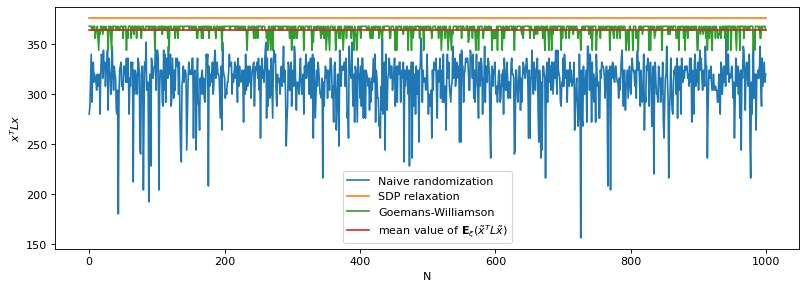

In [12]:
mean_y_res_gm = np.array(y_res_gm).reshape(1000,).mean()
fig = plt.figure( figsize=(12, 4), dpi=80 )
plt.plot(np.array(naive_randomization).reshape(1000,),  label = r'Naive randomization')
plt.plot(np.full((1000, ), y_res_sdp),  label = r'SDP relaxation')
plt.plot(np.array(y_res_gm).reshape(1000,),  label = r'Goemans-Williamson')
plt.plot(np.full((1000, ), mean_y_res_gm),  label = r'mean value of $\mathbf{E}_{\xi}\left(\tilde{x}^{T} L \tilde{x}\right)$')

plt.ylabel(r'$ x^{T} L x $')
plt.xlabel('N')
plt.legend()
plt.show()


### Problem 4: Linear Programming Example (3 points).
A cargo plane has three compartments for storing cargo: front, centre and rear. These compartments have the following limits on both weight and space:
$\begin{array}{lll}\text { Compartment } & \text { Weight capacity (tonnes) } & \text { Space capacity (cubic metres) } \\ \text { Front } & 10 & 6800 \\ \text { Centre } & 16 & 8700 \\ \text { Rear } & 8 & 5300\end{array}$


Furthermore, the weight of the cargo in the respective compartments must be the same proportion of that compartment's weight capacity to maintain the balance of the plane.
The following four cargoes are available for shipment on the next flight:


$\begin{array}{llll}\text { Cargo } & \text { Weight (tonnes) } & \text { Volume (cubic metres/tonne) } & \text { Profit (\$/tonne) } \\ \text { C1 } & 18 & 480 & 310 \\ \text { C2 } & 15 & 650 & 380 \\ \text { C3 } & 23 & 580 & 350 \\ \text { C4 } & 12 & 390 & 285\end{array}$


Any proportion of these cargoes can be accepted. The objective is to determine how much (if any) of each cargo C1, C2, C3 and C4 should be accepted and how to distribute each among the compartments so that the total profit for the flight is maximized.
1. Formulate the above problem as a linear program.
2. What assumptions you made in formulating this problem as a linear program?
3. Solve the problem (any appropriate package is ok, e.g. linprog in MatLab Optimization toolbox, scipy.optimize.linprog; see also CVX_byNikita.pdf)
4. Sensitivity to the constraint values. What if the available cargoes weight increases/decreases by $10 \%$ ? Which cargo's weight influence more to the total profit? Explain dependence between dual variables and changes in total profit.

#### Solution
(1)


Denote: 
- F = Front comparment 
- C = Center comparment 
- R = Rear comparment

Objective function: 
\begin{align*} 
\max \,\,\, 310(w_{1,F}+w_{1,C}+w_{1,R}) + 380(w_{2,F}+w_{2,C}+w_{2,R}) + 350(w_{3,F}+w_{3,C}+w_{3,R}) + 285(w_{4,F}+w_{4,C}+w_{4,R})
\end{align*}

Constraints:
\begin{align*} 
\sum_{i=1}^{4} w_{i,F} &\leq 10 \\
\sum_{i=1}^{4} w_{i,C} &\leq 16 \\
\sum_{i=1}^{4} w_{i,R} &\leq 8 \\
480 w_{1,F} + 650 w_{2,F} + 580 w_{3,F} + 390 w_{4,F} &\leq 6800 \\
480 w_{1,C} + 650 w_{2,C} + 580 w_{3,C} + 390 w_{4,C} &\leq 8700 \\
480 w_{1,R} + 650 w_{2,R} + 580 w_{3,R} + 390 w_{4,R} &\leq 5300 \\
w_{1,F} + w_{1,R} + w_{1,C} &\leq 18\\
w_{2,F} + w_{2,R} + w_{2,C} &\leq 15\\
w_{3,F} + w_{3,R} + w_{3,C} &\leq 23\\
w_{4,F} + w_{4,R} + w_{4,C} &\leq 12\\
\frac{\sum_{i=1}^{4} w_{i,F}}{ 10 } &= \frac{\sum_{i=1}^{4} w_{i,C}}{ 16 } \\
\frac{\sum_{i=1}^{4} w_{i,F}}{ 10 } &= \frac{\sum_{i=1}^{4} w_{i,R}}{ 8 } \\
\frac{\sum_{i=1}^{4} w_{i,C}}{ 16 } &= \frac{\sum_{i=1}^{4} w_{i,R}}{ 8 }
\end{align*} 


(2)

Assumption
- $w_{i,F}, w_{i,R}, w_{i,C} \in \mathbb{R}$  
- $w_{i,F}, w_{i,R}, w_{i,C} > 0$  

(3)

In [13]:
c = [-310,-310,-310, -380,-380,-380, -350,-350,-350, -285,-285,-285]
A_ieq = np.array([[1,0,0, 1,0,0, 1,0,0, 1,0,0],
              [0,1,0, 0,1,0, 0,1,0, 0,1,0],
              [0,0,1, 0,0,1, 0,0,1, 0,0,1],
              [480,0,0, 650,0,0, 580,0,0, 390,0,0],
              [0,480,0, 0,650,0, 0,580,0, 0,390,0],
              [0,0,480, 0,0,650, 0,0,580, 0,0,390],
              [1,1,1, 0,0,0, 0,0,0, 0,0,0],
              [0,0,0, 1,1,1, 0,0,0, 0,0,0],
              [0,0,0, 0,0,0, 1,1,1, 0,0,0],
              [0,0,0, 0,0,0, 0,0,0, 1,1,1]])
b_ieq = [10,16,8,6800, 8700, 5300,18,15,23,12]

A_eq= [[1/10,-1/16,0, 1/10,-1/16,0, 1/10,-1/16,0, 1/10,-1/16,0],
      [1/10,0,-1/8, 1/10,0,-1/8, 1/10,0,-1/8, 1/10,0,-1/8],
      [0,1/16,-1/8, 0,1/16,-1/8, 0,1/16,-1/8, 0,1/16,-1/8]]

b_eq = [0, 0, 0]

res = linprog(c, A_ub=A_ieq, b_ub=b_ieq,  A_eq=A_eq, b_eq=b_eq,options={"disp": False})
tot_profit = -res.fun
print(f"The maximum profit: $ {-res.fun}")

The maximum profit: $ 12151.578947230992


(4)

Sensitivity to the constraint values. What if the available cargoes weight increases/decreases by $10 \%$ ? Which cargo's weight influence more to the total profit? Explain dependence between dual variables and changes in total profit.

In [14]:
for i in range(1,5):
    b_ieq = [10,16,8,6800, 8700, 5300,18,15,23,12]
    b_ieq[-i] = b_ieq[-i]*0.9
    res = linprog(c, A_ub=A_ieq, b_ub=b_ieq,  A_eq=A_eq, b_eq=b_eq,options={"disp": False})
    print(f"If weight of cargo number {5-i} decrease by 10%, the maximum profit:  {100* abs(tot_profit+res.fun)/tot_profit}%")
    b_ieq[-i] = b_ieq[-i]*1.1
    res = linprog(c, A_ub=A_ieq, b_ub=b_ieq,  A_eq=A_eq, b_eq=b_eq,options={"disp": False})
    print(f"If weight of cargo number {5-i} increase by 10%, the maximum profit:  {100*abs(tot_profit+res.fun)/tot_profit}%\n")
    
    

If weight of cargo number 4 decrease by 10%, the maximum profit:  3.412968683406864e-10%
If weight of cargo number 4 increase by 10%, the maximum profit:  2.4624269667562682e-11%

If weight of cargo number 3 decrease by 10%, the maximum profit:  2.936350600601274e-10%
If weight of cargo number 3 increase by 10%, the maximum profit:  4.4832636871945435e-11%

If weight of cargo number 2 decrease by 10%, the maximum profit:  0.37032224496816163%
If weight of cargo number 2 increase by 10%, the maximum profit:  0.03703222435015431%

If weight of cargo number 1 decrease by 10%, the maximum profit:  4.020866307236482e-10%
If weight of cargo number 1 increase by 10%, the maximum profit:  4.355412084014815e-09%



- Cargo number 2 has tremendously influenced the price than others.
